# Exploring the Data from the Seasons of Game of Thrones using Pandas and Networkx
## - Question: Who were the most important Stark and Lannister main characters in the series?¶

Are you a fan of the witty Tyrion played by equally witty Peter Dinklage? Maybe you prefer the honorable Jon Snow , or the strong willed Arya? Are you house Stark or house Lannister? In any case my question is is your character the most important character in the show?

If you ask some people they will say Game of Thrones is known to be a show without a clear most important character, but how much is that true? We will find out using Network Analysis on our 2 favorite houses. This project will be best understood of you have knowledge of the show, however the approach can work on any show you desire.

## Table of Content

1. Define Narrative Importance
2. The Pre-Process
3. Stat Analysis of Game of Thrones Data
4. Apply Concat , Group , and Filter Steps to Seasons 1-7
5. Visualizing the Dataframes 
6. What Now?
7. Visualizing Graph Data
8. Final Insight

## 1. Define Narrative Importance:

Since the main goal involves measuring narrative importance we need to define what measuring narrative importance means. Every character in the edge dataframe is assigned to a target character and a corresponding Weight of the amount of scene interactions, so we can use that weight value.  

There are five interaction types. Character A and Character B are connected when:

1. Character A speaks directly after Character B
2. Character A speaks about Character B
3. Character C speaks about Character A and Character B
4. Character A and Character B are mentioned in the same stage direction
5. Character A and Character B appear in a scene together

We will use this value in 2 specific ways. The first way we will use the value is by counting the number of occurrences of it to use as the number of characters that character has interacted with. The second way is by summing all the weights for each character to use as the total number of interactions per character. The former gives us an idea of how much connections a character has in the story-- narrative connections , and the latter gives us an idea how much plot focuses on a character-- narrative focus. Both of which together we will use to measure narrative importance.





Examining how the csv files are organized we see a separation between a table of all the characters(nodes.csv) and
a table of all the relationships of those characters(edges.csv). These tables will be referred to as "Dataframes".

In the s1_edges dataframe: the 'Source' & 'Target' columns are the character nodes in the interactions and the 'Weight' column is the number of interactions by them in the scenes of the season.

In the s1_nodes dataframe: the 'Id' is the character name and 'Label' appears to be a casual version that the character is referenced by in the series. 

In [1]:
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt 
import numpy as np
from scipy.stats import skew

#Read in the csv files for season 1: season 1 edges and season 1 nodes
s1_edges = pd.read_csv('gameofthrones/data/got-s1-edges.csv')
s1_nodes = pd.read_csv('gameofthrones/data/got-s1-nodes.csv')

#Examine the first 5 rows of edges to get an idea of the columns and rows
s1_edges.head(5)

,Source,Target,Weight,Season
0,NED,ROBERT,192,1
1,DAENERYS,JORAH,154,1
2,JON,SAM,121,1
3,LITTLEFINGER,NED,107,1
4,NED,VARYS,96,1


In [2]:
#Examine the first 5 rows of nodes to get an idea of the columns and rows
s1_nodes.head(5)

,Id,Label
0,ADDAM_MARBRAND,Addam
1,AEGON,Aegon
2,AERYS,Aerys
3,ALLISER_THORNE,Allister
4,ARYA,Arya




## 2. The Pre-Process: 

### A. Creating the concat dataframe 
To start we will need to split the edges dataframe into 2 dataframes and duplicate the 'Weight' column. We do this because of the bi-directional nature of an interaction. Neither the 'Source' column nor 'Target' column by themselves reflect every character interaction in the show. Afterwards we take the 2 new dataframes and concat them to create a new dataframe that we will use for all our future analysis. 

To test that it was appended correctly we will filter the Weights from the first 2 rows of the original dataframe, and compare the new dataframes data with the original. This shows us that dataframe 1 was included first with 'Ned' and 'Daenerys' indexed at 0 and 1, then dataframe 2 shows up all the way after the length of dataframe 1 with 'Robert' and 'Jorah' indexed at 550 and 551. 

In [3]:
#Create identical column names and set the character id as index for manipulation
s1_edges_index = s1_edges.rename(columns={'Source':'Id'}).set_index('Id')
s1_nodes_index = s1_nodes.set_index('Id')
s1_edges_index.head(2) 

,Target,Weight,Season
Id,,,
NED,ROBERT,192,1
DAENERYS,JORAH,154,1


In [4]:
#Seperate the edges dataframe 'Source' & 'Target' columns into 2 dataframes, 
#Copying the 'Weight' column for both 'Source' & 'Target' characters
df_2 = s1_edges_index[['Target','Weight']].reset_index().drop(['Id'], axis=1).rename(columns={'Target':'Id'})
df_1 = s1_edges_index[['Weight']].reset_index()
#Concat the 2 dataframes together to have 1 dataframe that accounts every interaction from 'Source' & 'Target'
lis = pd.concat([df_1 , df_2], sort=False, ignore_index=True)
#Check to make sure concat is done correctly by filtering dataframe for the 
#Weights 192 , 154 ( the first 2 rows of S1_edges_index) and making sure the data remains the same
checkWeight192=lis.loc[lis['Weight']==192] 
checkWeight154=lis.loc[lis['Weight']==154] 
checkWeights = pd.concat([checkWeight192 , checkWeight154], sort=False , ignore_index=True)
checkWeights

,Id,Weight
0,NED,192
1,ROBERT,192
2,DAENERYS,154
3,JORAH,154


### B. Organize by sum and count  to measure narrative focus & narrative connections
Now that the main dataframe is created we can group all the characters in it by both Sum and Count. We put the results in new dataframes called df_sum and df_count. We will manipulate the Sum dataframe to measure narrative focus and the Count dataframe to measure narrative connections. As you can see the dataframes df_sum and df_count are a list of unique characters with the corresponding Sum or Count total. 

In [5]:
#Group the dataframe by the sum of all interactions per character
df_sum = lis.groupby(lis.Id)['Weight'].sum()

pd.DataFrame(df_sum.head(5))

,Weight
Id,
ADDAM_MARBRAND,8
AEGON,4
AERYS,41
ALLISER_THORNE,73
ARYA,373


In [6]:
#Group the dataframe by the count of characters interacted 
df_count = lis.groupby(lis.Id)['Weight'].count()
pd.DataFrame(df_count.head(5))

,Weight
Id,
ADDAM_MARBRAND,3
AEGON,2
AERYS,13
ALLISER_THORNE,8
ARYA,28


## 3. Stat Analysis of Game of Thrones Data:
### A. Measure distribution's skew , median and mean to learn how the narrative treats it's characters

Now let's view the distribution of all sum and count interactions. Even without checking the numbers you can see the distributions are skewed to the right. But we can confirm this by calculating the skew. Keeping in mind anything greater than 1 is highly skewed right, and we find our df_sum is greater than 3 and our df_count is greater than 2. This means the mean is greater than the median due to a couple of large values that push the mean higher. 

In terms of the story this skew means the season operates with a few characters getting most of the interactions and spotlight. These characters are clearly main characters with anything lower than these extreme values likely being different levels of side characters. The median which is unaffected by outliers gives us the clearest picture of the behavior of a typical side character. They had around 31 interactions on screen and interacted with around 6 characters. We care about the far right of our distributions to focus our analysis on the main characters. Let’s use the top 5% of total interactions and number of characters interacted to indicate major characters in a season.


	Skew
Sum:  3.4116588193958335  Count:  2.1968309865667


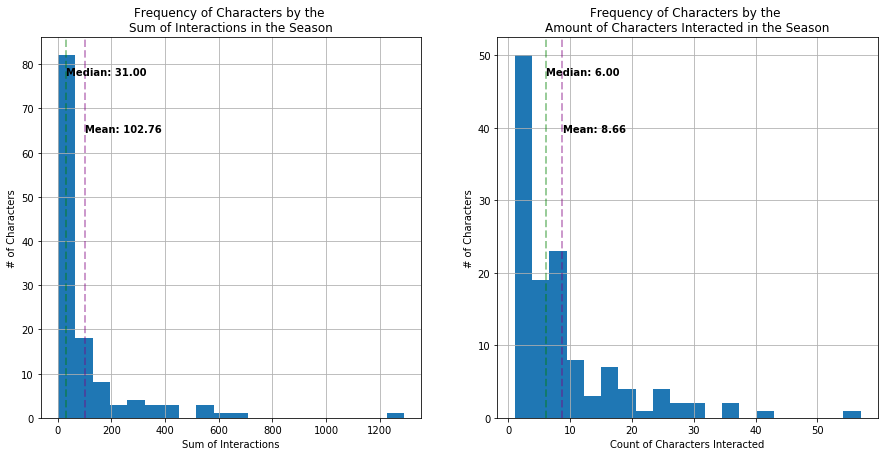

In [7]:
#The skew is greater than 1 so it is highly skewed to the right
print('\tSkew\nSum: ', skew(df_sum),' Count: ', skew(df_count))


#Create 2 histographs to see the distribution of the Sum and Count dataframes
plt.subplot(121)
plt.title('Frequency of Characters by the \nSum of Interactions in the Season')
df_sum.hist(figsize=(15, 7), bins=20) 
plt.axvline(df_sum.mean(), color='purple', linestyle='dashed', linewidth=2, alpha=.4)
plt.axvline(df_sum.median(), color='green', linestyle='dashed', linewidth=2, alpha=.4)
plt.ylabel('# of Characters')
plt.xlabel('Sum of Interactions')
_, max_ = plt.ylim()
plt.text(df_sum.mean() + df_sum.mean()*.01, max_ - max_*.25, 'Mean: {:.2f}'.format(df_sum.mean()), weight='bold')
plt.text(df_sum.median() + df_sum.median()*.01 , max_-max_*.1 ,'Median: {:.2f}'.format(df_sum.median()), weight='bold')



plt.subplot(122)
plt.title('Frequency of Characters by the \nAmount of Characters Interacted in the Season')
df_count.hist(figsize=(15, 7), bins=20)
plt.axvline(df_count.mean(), color='purple', linestyle='dashed', linewidth=2, alpha=.4)
plt.axvline(df_count.median(), color='green', linestyle='dashed', linewidth=2, alpha=.4)
plt.ylabel('# of Characters')
plt.xlabel('Count of Characters Interacted')
_, max_ = plt.ylim()
plt.text(df_count.mean() + df_count.mean()*.01, max_ - max_*.25, 'Mean: {:.2f}'.format(df_count.mean()), weight='bold')
plt.text(df_count.median() + df_count.median()*.01 , max_-max_*.1 ,'Median: {:.2f}'.format(df_count.median()), weight='bold')
plt.show()


### B. Filtering using the stats
Let's filter and sort our values to learn the names of our most important characters.  First we will calculate the 95 percentile of our df_sum and df_count. We will round the 95 percentiles down, then add 1 to the resulting numbers to give us the lower border of the top 5% range for the amount of total interactions and characters interacted. We round down the numbers because an interaction or character cannot be a decimal number. We add 1 because one value above the 95 percentile starts the top 5%.

For example: For df_sum the bottom 95% of total interactions end at 437.99 interactions. We round down to get the value of 437 interactions or higher for the top 5%. By adding 1 to this value we learn that the lower border for the top 5% of total interactions is 438.  The same method applied to df_count gives us the true lower border value of 28 characters interacted or higher for the top 5%.

### C. Insights
When we filter those values into our dataframes we get the list of characters for the top 5%. It seems like the two dataframes contain allot of the same characters, but in a different order. My theory is the different order exists because of the isolation of certain important characters from the central conflict of the season. As well as certain less focused on characters who are part of the central Lannister-Stark conflict, and so interact with an unusually high amount of characters for their current focus in the plot. To support my theory I will explain the character differences.


Cersei is on both lists in a different rank order. She is 5th on the Count dataframe and 6th on the Sum dataframe. This I believe is a consequence of all the other additions to the Sum dataframe. Jon and Daenerys are both on the Sum dataframe and not on the Count dataframe. This abnormality is due to the isolation of their narratives compared to everyone else. Robb and Arya are similarly only on the Count dataframe, and they are both future main characters entangled in the central Stark-Lannister conflict despite not being focused on heavily in the narrative yet. This is probably why they have a high number of characters interacted. 



In [8]:
#Calculate the 95th percentile to find where the top 5% of all summed interactions start
#Then filter the dataframe using that information to list the characters involved 
print('Top 5% of total interactions were {:0.0f} interactions or higher \n'.format
      ((np.floor(df_sum.quantile(.95))+1)))

Top5_Sum=df_sum.loc[lambda x:x>=np.floor(df_sum.quantile(.95))+1].sort_values(ascending=False).reset_index()
print('This top 5% involves the following characters: \n')
Top5_Sum

Top 5% of total interactions were 438 interactions or higher 

This top 5% involves the following characters: 



,Id,Weight
0,NED,1290
1,TYRION,708
2,CATELYN,584
3,ROBERT,563
4,JON,535
5,DAENERYS,535
6,CERSEI,444


In [9]:
#Calculate the 95th percentile to find where the top 5% of all counted interactions start
#Then filter the dataframe using that information to list the characters involved 
print('Top 5% of total characters interacted were {:0.0f} number of characters interacted or higher \n'.format
      ((np.floor(df_count.quantile(.95))+1)))
Top5_Count = df_count.loc[lambda x:x>=np.floor(df_count.quantile(.95)+1)].sort_values(ascending=False).reset_index()
print('This top 5% involves the following characters: \n')
Top5_Count

Top 5% of total characters interacted were 28 number of characters interacted or higher 

This top 5% involves the following characters: 



,Id,Weight
0,NED,57
1,TYRION,41
2,CATELYN,37
3,ROBERT,36
4,ROBB,30
5,CERSEI,29
6,ARYA,28


### D. Filtering only the Lannisters and Starks
Now that we know the stats we are using to filter the characters and the results we get from doing so let's now focus on just the main characters that are Lannisters and Starks. For our analysis we will only define Lannisters and Starks to be the members of the family that would potentially be on the far right of the distribution. No side characters, or characters that are absent for large periods.

In [10]:
#Filter Top5_Count for Starks and Lannisters 
Lannisters = ['TYRION','TYWIN','CERSEI','JAIME']
Starks = ['NED', 'CATELYN', 'ROBB','JON','SANSA','ARYA']
Main_Char = Lannisters + Starks
Top_LanC = Top5_Count[Top5_Count['Id'].isin(Lannisters)]
Top_StarC = Top5_Count[Top5_Count['Id'].isin(Starks)]
Top_LanS = Top5_Sum[Top5_Sum['Id'].isin(Lannisters)]
Top_StarS = Top5_Sum[Top5_Sum['Id'].isin(Starks)]
print('Top 5 Lannisters Ranks(Count)\n')
Top_LanC


Top 5 Lannisters Ranks(Count)



,Id,Weight
1,TYRION,41
5,CERSEI,29


In [11]:
print('TOp 5 Lannisters Ranks(Sum)\n')
Top_LanS


TOp 5 Lannisters Ranks(Sum)



,Id,Weight
1,TYRION,708
6,CERSEI,444


In [12]:
print('Top 5 Starks Ranks(Count)\n')
Top_StarC

Top 5 Starks Ranks(Count)



,Id,Weight
0,NED,57
2,CATELYN,37
4,ROBB,30
6,ARYA,28


In [13]:
print('Top 5 Starks Ranks(Sum)\n')
Top_StarS

Top 5 Starks Ranks(Sum)



,Id,Weight
0,NED,1290
2,CATELYN,584
4,JON,535


## 4. Apply Concat , Group , and Filter Steps to Seasons 1-7:

### A. Create the function for all the seasons
Now let's turn what we have done so far into a function , and then compare the Lannister & Stark characters throughout the seasons. We can see how important each character was for each season.


In [14]:
def ranking(df, isSum):
    #Extract Target & Source columns with the assigned Weights
    #Rename the Target & Source column name into Id
    df2 = df[['Target','Weight']].rename(columns={'Target':'Id'})
    df1 = df[['Source','Weight']].rename(columns={'Source':'Id'})
    #Concat the 2 dfs 
    df_main = pd.concat([df2 , df1], sort=False, ignore_index=True)
    #If True use Sum function else use Count function
    if isSum:
        df_groupby = df_main.groupby(df_main.Id)['Weight'].sum()
    else:
        df_groupby = df_main.groupby(df_main.Id)['Weight'].count()
    #Calculate the interaction Sum or Count number that is the 95 percentile of the interaction range   
    percentile95 = np.floor(df_groupby.quantile(.95))+1 
    #Filter the interaction range for that 95 percentile number or larger to get the top 5% and Sort them
    Top5=df_groupby.loc[lambda x:x>=percentile95].sort_values(ascending=False).reset_index()
    #Filter the characters for Lannisters & Starks
    Top5 = Top5[Top5['Id'].isin(Main_Char)]
    #Fix index so that it represents ranks 1 through 6
    Top5.index = np.arange(1, len(Top5)+1)
    #Create a dictionary using both character names and their rank
    pairs = dict(zip(Top5['Id'],Top5.index))
    return pairs


### B. Apply the function to prepare for visualization

In [15]:
#Using techniques on Season 1-7. Finding and comparing the Sum and Count rankings of the 
#top 1% of characters in each season
seasons = ['gameofthrones/data/got-s1-edges.csv','gameofthrones/data/got-s2-edges.csv', 'gameofthrones/data/got-s3-edges.csv','gameofthrones/data/got-s4-edges.csv', 
 'gameofthrones/data/got-s5-edges.csv', 'gameofthrones/data/got-s6-edges.csv', 'gameofthrones/data/got-s7-edges.csv']

season1to7_Sum = {}
season1to7_Count = {}
for i , s in enumerate(seasons, start=1): 
    edges = pd.read_csv(s) 
    a = ranking(edges, True)
    b = ranking(edges, False)
    season1to7_Sum[i]=a
    season1to7_Count[i]=b
#Turn dictionaries into DataFrames and turn NAN into 10 ( > Rank 8 = Irrelevant )
df_rank_S_pre = pd.DataFrame(season1to7_Sum).fillna(10).rename(columns={1:'S1' , 2:'S2' , 3:'S3', 4:'S4', 5:'S5', 6:'S6', 7:'S7'})
df_rank_C_pre = pd.DataFrame(season1to7_Count).fillna(10).rename(columns={1:'S1' , 2:'S2' , 3:'S3', 4:'S4', 5:'S5', 6:'S6', 7:'S7'})
#Apply function to dataframes to turn <10 into 1 and 10 into 0
df_rank_C = df_rank_C_pre.applymap(lambda s: 1 if s<10 else 0 )
df_rank_S= df_rank_S_pre.applymap(lambda s: 1 if s<10 else 0 )
#Create a list that assigned colors red or blue depending on if Lannister or Starks
color = ['r' if n in Lannisters else 'b' for n in df_rank_S.index]

As you can see the function originally gives us a dataframe for both Sum and Count that displays the rank of the characters between 1 to 6. For any season where I character does not land on the top 5% we fill that in with a 10.

For plotting purposes we will not be visualizing this format we will be counting how many times a character reaches the top 5%. The reasons is for our purposes reaching the top 5% in any order is the important indication for narrative focus and narrative connections, and it is easier to compare the counts. This will be achieved by filling in a 0 for any place a 10 is and turning the rest into 1. 


In [16]:
print('--Count--\n',df_rank_C_pre, '\n', '\n--Sum--\n',df_rank_S_pre)

--Count--
            S1    S2    S3    S4    S5    S6    S7
ARYA      6.0   4.0  10.0  10.0  10.0  10.0  10.0
CATELYN   3.0   6.0   4.0  10.0  10.0  10.0  10.0
CERSEI    5.0   2.0   5.0   2.0   1.0   3.0   3.0
JAIME    10.0  10.0  10.0   5.0  10.0   5.0  10.0
JON      10.0  10.0  10.0   4.0   2.0   2.0   1.0
NED       1.0  10.0  10.0  10.0  10.0   6.0  10.0
ROBB      4.0   3.0   1.0  10.0  10.0  10.0  10.0
SANSA    10.0  10.0  10.0   3.0   3.0   1.0  10.0
TYRION    2.0   1.0   3.0   1.0  10.0   4.0   2.0
TYWIN    10.0   5.0   2.0   6.0  10.0  10.0  10.0 
 
--Sum--
            S1    S2    S3    S4    S5    S6    S7
ARYA     10.0   3.0  10.0  10.0  10.0   6.0  10.0
CATELYN   3.0  10.0  10.0  10.0  10.0  10.0  10.0
CERSEI    5.0   2.0   5.0   2.0   1.0   5.0   3.0
JAIME    10.0  10.0   6.0   3.0  10.0   4.0  10.0
JON       4.0  10.0   7.0   5.0   2.0   1.0   1.0
NED       1.0  10.0  10.0  10.0  10.0  10.0  10.0
ROBB     10.0   4.0   2.0  10.0  10.0  10.0  10.0
SANSA    10.0  10.0   4.0  

In [17]:
print('The number of times each character reached the top 5% \nfor each season measured by number of characters interacted:\n')
df_rank_C


The number of times each character reached the top 5% 
for each season measured by number of characters interacted:



,S1,S2,S3,S4,S5,S6,S7
ARYA,1,1,0,0,0,0,0
CATELYN,1,1,1,0,0,0,0
CERSEI,1,1,1,1,1,1,1
JAIME,0,0,0,1,0,1,0
JON,0,0,0,1,1,1,1
NED,1,0,0,0,0,1,0
ROBB,1,1,1,0,0,0,0
SANSA,0,0,0,1,1,1,0
TYRION,1,1,1,1,0,1,1
TYWIN,0,1,1,1,0,0,0


In [18]:
print('The number of times each character reached the top 5% \nfor each season measured by number of total interactions:\n')
df_rank_S

The number of times each character reached the top 5% 
for each season measured by number of total interactions:



,S1,S2,S3,S4,S5,S6,S7
ARYA,0,1,0,0,0,1,0
CATELYN,1,0,0,0,0,0,0
CERSEI,1,1,1,1,1,1,1
JAIME,0,0,1,1,0,1,0
JON,1,0,1,1,1,1,1
NED,1,0,0,0,0,0,0
ROBB,0,1,1,0,0,0,0
SANSA,0,0,1,1,1,1,0
TYRION,1,1,1,1,1,1,1
TYWIN,0,0,1,1,0,0,0


## 5. Visualizing the Dataframes 

### A. Graph visualizing sum

After applying the function we first get a bar chart plot of the number of seasons each Stark and Lannister is in the top 5% for the total interactions for each respective season. Starks are in blue and Lannisters are in red. As a reminder interactions also account for a character talking about another or have the 2 characters mentioned together. So it is possible to have interactions while being dead in the story.

As you can see there are less Lannisters than Starks, even if we only focus on those that are alive after season 7. Despite this fact, the Lannisters dominate top 5% in total interactions. Cersei and Tyrion are the only characters of them all to always be present on the top 5% for every season. The highest Stark is Jon who is only in the top 5% for 6 out of the 7 seasons. The lowest Lannister Tywin reaches the top 5% for 2 out of 7 seasons while the lowest Starks Ned & Catelyn reach the top 5% for only 1 out of 7 seasons.

Considering that in a T.V series every interaction should move the plot in some way or develop the characters it can be suggested that while we follow more of the Starks it is the Lannisters that are the narrative focus and truly develop the plot. The dynamic between Tyrion who is usually considered a good guy and Cersei who is usually the antithesis to Tyrion seems to get more scenes than the Stark and Lannister conflict. Just by number of scenes the main protagonist would be Tyrion and the antagonist would be Cersei, but lets look at number of characters interacted before making that judgment.


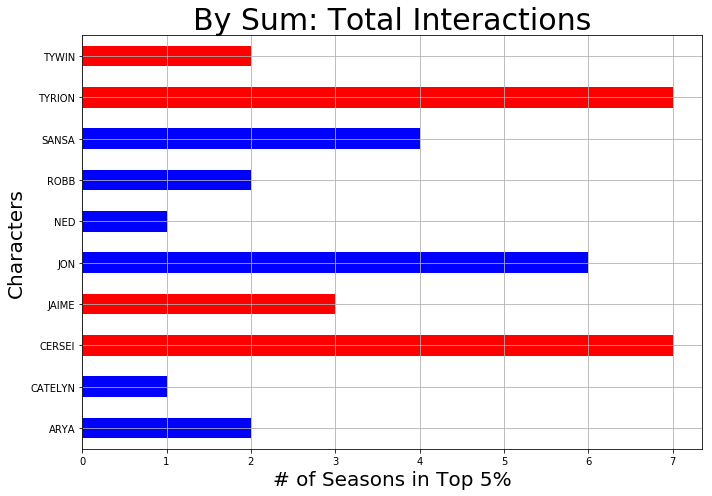

In [19]:
#Plot the Transpose of df_rank_S to create a bar plot 
plt.figure(figsize=(10,7))
plt.title('By Sum: Total Interactions', fontsize=30)
plt.xlabel('# of Seasons in Top 5%',fontsize=20)
plt.ylabel('Characters',fontsize=20)
df_rank_S.T.sum().plot(kind='barh', color=color)
plt.grid()
plt.tight_layout()
plt.show()

### B. Graph visualizing count

After applying the function we first get a bar chart plot of the number of seasons each Stark and Lannister is in the top 5% for the number of characters interacted with for each respective season. Again Starks are in blue and Lannisters are in red. Cersei again is on the top 5% for all 7 seasons and this time she beats even Tyrion by 1 season. They both beat the highest Stark Jon who only reaches the top 5% for 4 out of the 7 seasons, however this time on the lower spectrum Jaime , Arya and Ned share the lowest seasons on the top 5% at 2 seasons. The last Lannister member Tywin is even with rest of the Starks. 

Considering the number of narrative connections that character has can suggest a characters influence in the story. It is possible to have low narrative focus but high influence, and visa vi. A classic example of this dynamic is in the first few Harry Potter books most main characters have a higher narrative focus than Lord Voldemort , but his influence is not measured by how many scenes he is in or how many times 1 character talks about him. It is measured by how many characters talk about him. That makes Lord Voldemort an influential character with many narrative connections even when he is not personally developing each books plot.

Using this plot we can see that allot of characters have the same number of seasons of comparably high narrative connections. With some like Ned having more top 5% seasons in connections & influence than they have seasons alive. Another interesting fact can be seen when you consider how long each character was alive. Catelyn and Robb were only alive for 3 seasons, and still developed as much or more seasons in the top 5% for narrative connections than Sansa and Arya. Both of which are still alive in Season 7. Hence besides Jon most Starks just have not developed high narrative connections throughout seasons consistently or those that did died early in the story. Again the Lannister members Cersei and Tyrion are the most influential in the story with Jon being a far third. 



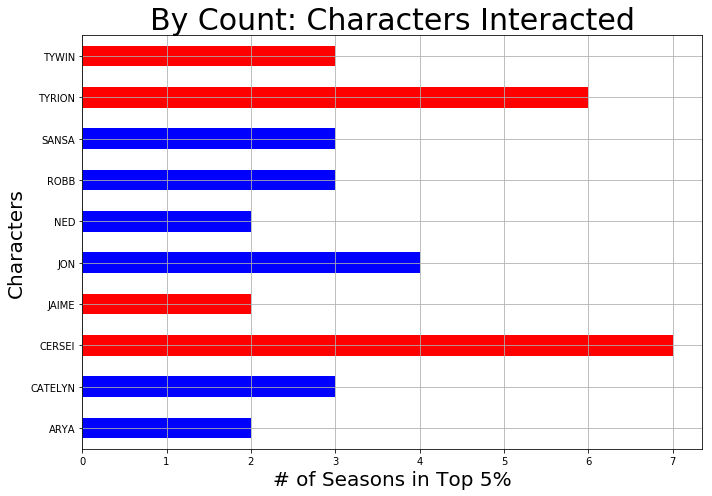

In [20]:
#Plot the Transpose of df_rank_C to create a bar plot 
plt.figure(figsize=(10,7))
plt.title('By Count: Characters Interacted',fontsize=30)
plt.xlabel('# of Seasons in Top 5%', fontsize=20)
plt.ylabel('Characters',fontsize=20)
df_rank_C.T.sum().plot(kind='barh', color=color)
plt.grid()
plt.tight_layout()
plt.show()


### C. Insights--the characters of highest narrative importance:

The main characters of the highest narrative importance are Tyrion and Cersei for the Lannisters, and Jon for the Starks. As you can see in the following bar graph all 3 characters have 4 or more seasons in the top 5% for both total interactions and number of characters interacted with. This means they are on the top 5% more than half the series length so far.

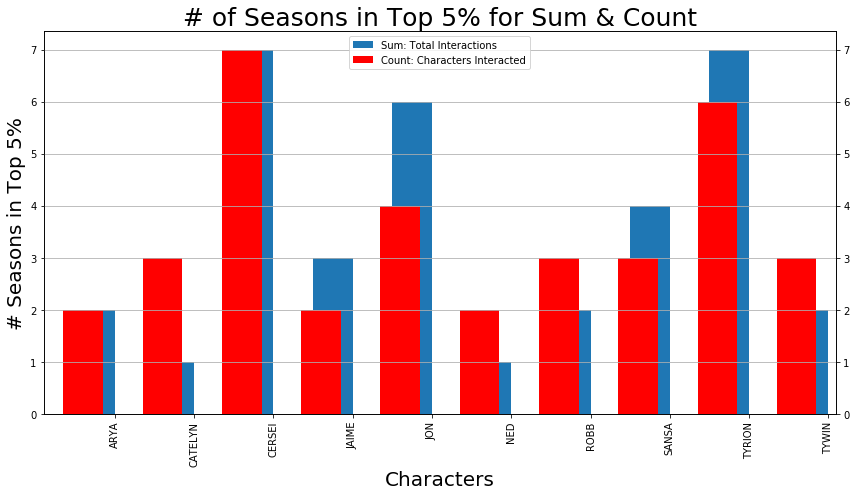

In [28]:
#Sum the Count and Sum dfs to create 2 series of the number of seasons on top 5% for each character
counted= df_rank_C.T.sum() 
summed= df_rank_S.T.sum() 
#Create plot and assign an axis for each series
fig = plt.figure(figsize=(12,7))
plt.title('# of Seasons in Top 5% for Sum & Count', fontsize=25)
ax = fig.add_subplot(111)
ax2 = ax.twinx()
ax.set_xlabel('Characters' , fontsize=20)
ax.set_ylabel('# Seasons in Top 5%', fontsize=20)
summed.plot(kind='bar',  ax=ax, position=1, label='Sum: Total Interactions')
counted.plot(kind='bar', ax=ax2, color='r',position=1.3, label='Count: Characters Interacted')
#Get the labels for each axis to make a legend
h1,l1 =ax.get_legend_handles_labels()
h2, l2=ax2.get_legend_handles_labels()
plt.legend(h1+h2,l1+l2, loc='upper center' )
plt.grid()
plt.tight_layout()
plt.show() 

## 6. What Now? 

Before we tested Narrative Connections and Narrative Focus to find our 3 characters: Cersei , Tyrion & Jon. All 3 characters have a high level of scenes focused on them and a high number of characters they interact with. What other metric can we use to determine importance? Besides the sheer number of something we also want to know the quality. So now let's pose a new question: 

### A. New Question:  Who has the most meaningful relationships out of the narrative important Starks and Lannisters?


To determine how meaningful the characters relationships are we will test for important relationships within and between each family to learn whom our characters have important relationships with. We will do this by visualizing using Networkx the relationships between the Stark family members , the Lannister family members , and last the relationships between each family. Networkx is a python module used for creating network graphs and finding out information about how the each node in the graph relates to each other.

### B. Define important relationships and terminology
For our concern an important relationship is any relationship with a weight that is in the top 5% range of all the season's relationship weights.  The reason we are defining it like that is because we want to find relationships that include a high frequency of interactions , and we want to calculate this frequency compared to other relationships in the same season.

Some terminology to keep in mind:

1. Nodes- The entities that are part of the relationship

2. Edges - The connection or relationship that is defined


In [22]:
#Create list with seasons 1-7 edge csv files
Slist= ['gameofthrones/data/got-s1-edges.csv','gameofthrones/data/got-s2-edges.csv', 'gameofthrones/data/got-s3-edges.csv','gameofthrones/data/got-s4-edges.csv', 
 'gameofthrones/data/got-s5-edges.csv', 'gameofthrones/data/got-s6-edges.csv', 'gameofthrones/data/got-s7-edges.csv']
#Create a graph object and iterate throw the rows of the season 1 dataframe to add edges to graph
G_S1 = nx.Graph()
S1 = pd.read_csv(Slist[0])
for _ , edge in S1.iterrows():
    G_S1.add_edge(edge['Source'], edge['Target'] , weight=edge['Weight'], season='1')
pd.DataFrame(G_S1.edges(data=True)).head().rename(columns={0: 'node1',1:'node2',2:'Interaction Weight/Season'})

,node1,node2,Interaction Weight/Season
0,NED,ROBERT,"{'weight': 192, 'season': '1'}"
1,NED,LITTLEFINGER,"{'weight': 107, 'season': '1'}"
2,NED,VARYS,"{'weight': 96, 'season': '1'}"
3,NED,ARYA,"{'weight': 90, 'season': '1'}"
4,NED,CERSEI,"{'weight': 86, 'season': '1'}"


----

## 7. Visualizing Graph Data
### A. Apply  networking analysis to season 1
A network graph is a collection of nodes connected by edges which in this case are weighted by the frequency of interactions. We are highlighting all relationships that satisfy our definition of importance in blue. For season 1 this means 3 specific relationships:

1. Robb and Catelyn
2. Cersei and Ned
3. Ned and Arya


Out of the 3 relationships only one includes a character we defined as narrative important--Cersei. Her most important relationship in season 1 was with Ned. This means that no matter how many other connections Ned and Cersei had in season 1 , only the connection between them was at a frequency high enough to be considered important. We will repeat this process for all 7 seasons and visualize them in one graph.


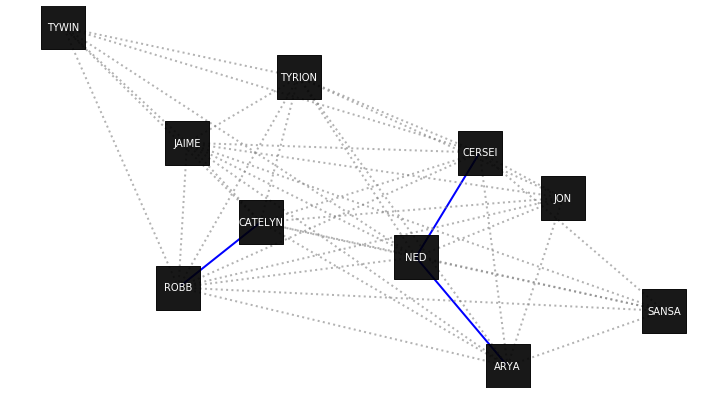

In [27]:
#Create a subgraph without characters that are not Lannisters/Starks
H = G_S1.subgraph(Main_Char)
#Create a function to check which family that characters interacting are from 
def checkInteract(s , t):
    if s in Starks and t in Starks:
        return 0
    elif s in Lannisters and t in Lannisters:
        return 1
    else:
        return 3
#Create a position layout for the graph    
pos = nx.spring_layout(H, scale=3)


#Create list of edge weights and find 95 percentile 
weights = np.array([(H[u][v]['weight']) for u,v in H.edges()])
p95 = np.floor(np.percentile(weights , 95))

#Plot figure
plt.figure(figsize=(12,7))
#Draw and style nodes 
nx.draw_networkx_nodes(H, pos, node_size=2000, node_shape='s', alpha=.9, node_color='black')
#Take all edges a sort them into elarge/emedium by if weight >= 95 percentile
elarge = [(u, v) for (u, v, d) in H.edges(data=True) if d['weight'] >=p95]
emedium = [(u, v) for (u, v, d) in H.edges(data=True) if d['weight'] <p95]
#Draw and style edge lines using elarge and emedium lists
nx.draw_networkx_edges(H, pos, edgelist=elarge,width=2 , alpha=1 , edge_color='b')
nx.draw_networkx_edges(H, pos, edgelist=emedium,width=2, alpha=.6, edge_color='grey', style='dotted')
#Draw and style node labels (character names)
nx.draw_networkx_labels(H, pos, font_size=10, font_color='w')
plt.axis('off')
plt.show()


### B. Applying network analysis to seasons 1-7
### - Stark vs Stark

In this graph only the important relationships are shown for all seasons, however, because the seasons are not guaranteed to contain a relationship that has an interaction amount in the top 5% range some seasons may be missing. 

The blue line shows us the flow of important(highly frequent) relationships in season 1. The first thing you notice is what every Stark but Jon is connected. This further emphasizes Jon's role as a loner that has no important relationships with his family in season 1. Another observation is how exactly the other Starks are connected by the blue line. Ned is connected only to Arya and Catelyn is connected only to Robb. So Ned does not interact to a high degree with Sansa or Robb, and Cateyln does not interact to a high degree with Arya or Sansa. Essentially this means Jon is not the only Stark ignored. Every Stark parent has their favorite.

The gray line shows us the flow of important relationship in season 6. Once again the number of connections is only 1, which is Jon and Sansa. This can be explained as this is when in the story both character's story converges. The moment is also worth focusing on because it is the first time Jon ever connected on the graph with any other Stark, which symbolizes in the story Jon's growth from a black sheep to a part of the Stark herd. 

Lastly the yellow line shows us the flow of important (highly frequent) relationships in season 7. Now Arya has come home as well to interact with Sansa. It is important to note that neither Sansa nor Arya connect with Jon this season. Even though Jon by now is the main focus in the Starks he still is isolated from the Starks arc. From season 1 to season 7 the narrative focus on the Starks transitions from Parent-Parent , to Parent-Child , and eventually from Sibling-Sibling. As this transition happened the connections traveled slowly reaching Jon. Even when they reached him the story still treats him as 'not a real stark'.

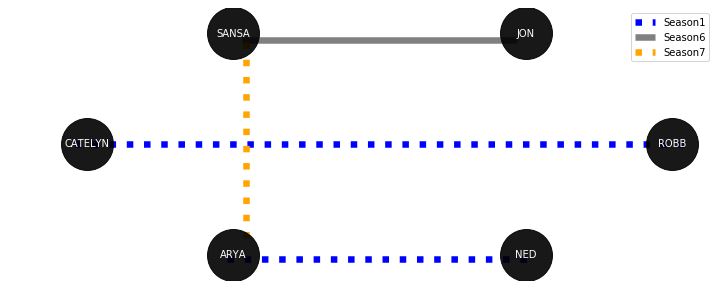

In [24]:
#Create default values for Glist (list of graphs) & s_num( season number)
Glist = []
s_num = 1
#Loop through seasons to create graph objects with edge data and append them to Glist
for season in Slist:
    S = pd.read_csv(season)
    G = nx.Graph()
    for _ , edge in S.iterrows():
        G.add_edge(edge['Source'], edge['Target'] , weight=edge['Weight'] , season=str(s_num))
    Glist.append(G)
    s_num+=1
#Create multi graph object for 7 graphs 
mg = nx.MultiGraph()
#Loop through graph objects and add data to multi graph object
for i in range(7):
    mg.add_weighted_edges_from(Glist[i].edges(data=True))

    
#Filter multi graph for Stark nodes , extract weights and assign 95 percentile
sub = mg.subgraph(Starks)
weights1to7 = np.array([(d['weight']['weight']) for u,v,d in sub.edges(data=True)])
p95 = np.floor(np.percentile(weights1to7 , 95))
#Create default values for Poslist(List of graph layout positions) and scale (scale of layout)
Poslist= []
scale=1
#Loop through layout posotions to create a list of different aligned positions
#We alter the scale so that we can see each line without them overlapping
for i in range(7):
    posN = nx.shell_layout(sub, scale=scale)
    Poslist.append(posN)
    scale-=.02
    
#Create plot figure
plt.figure(figsize=(12,5))
#Draw and style nodes & labels
nx.draw_networkx_nodes(sub, Poslist[2], node_size=2700, node_shape='o', alpha=.9, node_color='black')
nx.draw_networkx_labels(sub, Poslist[2], font_size=10, font_color='w')
#Loop through edges to find edges that are in the top 5% and assign them to a list
large=[]
for i in range(7):
        elarge = [(u, v) for (u, v, d) in sub.edges(data=True) if d['weight']['weight'] >=p95 and d['weight']['season']==str(i+1)]
        large.append(elarge)
#Create a list of colors and styles to loop through
cs = [('b','dotted'),('r','dotted') ,( 'g','dotted'), ('y','dashed'), ('pink','dashed') , ('grey','solid'),('orange','dotted')]
#Loop to draw and style edge lines
for i in range(7):
    nx.draw_networkx_edges(sub, Poslist[i], edgelist=large[i],width=6.5, alpha=1 ,label='Season'+str(i+1), edge_color=cs[i][0], style=cs[i][1])
plt.legend()
plt.axis('off')
plt.show()


### - Lannister vs Lannister

The red line shows the important Lannister relationship for season 2, which is Cersei and Tyrion. This is the season in which their rivalry really took off as they both manipulated the throne in Kings Landing. The purple line shows the important Lannister relationship for season 4, which is Tyrion and Jaime. The yellow line shows the important Lannister relationship for season 7. This is between Jaime and Cersei. It is noticeable that unlike the Starks all of the Lannisters except Tywin throughout the seasons connect through out the season creating a triangle of importance.

This is probably because all of the Lannisters are often in one place or are part of the same story thread. In either case it seems like both Tyrion and Cerzei have an equal amount of important relationships in the Lannister family. Neither have frequent relationships with their father and both have it with their brother.

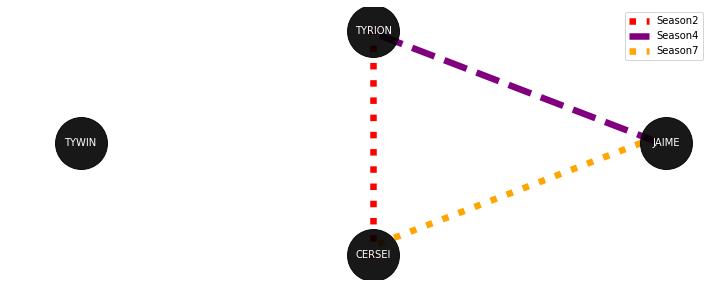

In [25]:
#Filter multi graph for Lannister nodes , extract weights and assign 95 percentile
sub2 = mg.subgraph(Lannisters)
weights2_1to7 = np.array([(d['weight']['weight']) for u,v,d in sub2.edges(data=True)])
p2_95 = np.floor(np.percentile(weights2_1to7 , 95))
#Create default values for Poslist(List of graph layout positions) and scale (scale of layout)
Poslist2= []
scale2=1
#Loop through layout posotions to create a list of different aligned positions
#We alter the scale so that we can see each line without them overlapping
for i in range(7):
    posN2 = nx.shell_layout(sub2, scale=scale2)
    Poslist2.append(posN2)
    scale2-=.02
#Create plot figure
plt.figure(figsize=(12,5))
#Draw and style nodes & labels
nx.draw_networkx_nodes(sub2, Poslist2[2], node_size=2700, node_shape='o', alpha=.9, node_color='black')
nx.draw_networkx_labels(sub2, Poslist2[2], font_size=10, font_color='w')
#Loop through edges to find edges that are in the top 5% and assign them to a list
large2=[]
for i in range(7):
        elarge2 = [(u, v) for (u, v, d) in sub2.edges(data=True) if d['weight']['weight'] >=p2_95 and d['weight']['season']==str(i+1)]
        large2.append(elarge2)
#Create a list of colors and styles to loop through
cs = [('b','dotted'),('r','dotted') ,( 'g','dotted'), ('purple','dashed'), ('pink','dashed') , ('grey','solid'),('orange','dotted')]
#Loop to draw and style edge lines
for i in range(7):
    nx.draw_networkx_edges(sub2, Poslist2[i], edgelist=large2[i],width=6.5, alpha=1 ,label='Season'+str(i+1), edge_color=cs[i][0], style=cs[i][1])
plt.legend()
plt.axis('off')
plt.show()


### - Lannister vs Stark


Finally let's look at solely the interactions for all 7 seasons that are between a Lannister and a Stark. Season 2 is Tywin with Arya. Season 7 involves Tyrion and Jon. What this means is that only these 2 relationships have a weight frequency of interactions in the top 5% of all Lannister & Stark weighted interactions. As such even though Tyrion and Cersei are equal in important relationships in the Lannister family Tyrion has important relationships outside the family too.


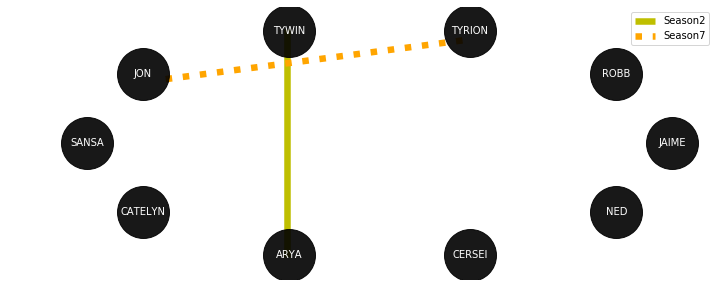

In [26]:
#Filter multi graph for Lannister nodes , extract weights and assign 95 percentile
sub3 = mg.subgraph(Main_Char)
weights3_1to7 = np.array([(d['weight']['weight']) for u,v,d in sub3.edges(data=True)])
p3_95 = np.floor(np.percentile(weights3_1to7 , 95))
#Create default values for Poslist(List of graph layout positions) and scale (scale of layout)
Poslist3= []
scale3=1
#Loop through layout posotions to create a list of different aligned positions
#We alter the scale so that we can see each line without them overlapping
for i in range(7):
    posN3 = nx.shell_layout(sub3, scale=scale3)
    Poslist3.append(posN3)
    scale3-=.02
#Create plot figure    
plt.figure(figsize=(12,5))
#Draw and style nodes & labels
nx.draw_networkx_nodes(sub3, Poslist3[2], node_size=2700, node_shape='o', alpha=.9, node_color='black')
nx.draw_networkx_labels(sub3, Poslist3[2], font_size=10, font_color='w')
#Loop through edges to find edges that are in the top 5% and assign them to a list
large3=[]
for i in range(7):
        elarge3 = [(u, v) for (u, v, d) in sub3.edges(data=True) if d['weight']['weight'] >=p3_95 and d['weight']['season']==str(i+1) and checkInteract(u,v)==3]
        large3.append(elarge3)
#Create a list of colors and styles to loop through        
cs = [('b','dotted'),('y','solid') ,( 'g','dashed'), ('purple','dotted'), ('pink','dashed') , ('grey','solid'),('orange','dotted')]
#Loop to draw and style edge lines
for i in range(7):
    nx.draw_networkx_edges(sub3, Poslist3[i], edgelist=large3[i],width=6.5, alpha=1 ,label='Season'+str(i+1), edge_color=cs[i][0], style=cs[i][1])
plt.legend()
plt.axis('off')
plt.show()


## 8. Final Insight

Of the 3 most narrative important characters our analysis of their important relationships gives the following insight:

- Tyrion has important relationships inside the Lannister Family and outside with the Starks. He also has the most important relationships with 3 in total. 

- Cersei has important relationships only inside the Lannister family. She has 2 important relationships in total.

- Jon has important relationships inside the Stark Family and outside with the Lannisters. He has 2 important relationships in total.

###  The most important character is 
Tyrion, he is the character with the high narrative importance, and he has the largest number of meaningful important relationships inside and outside his own family. 
